# Machine Learning Project: (Group 20)
- Ahad Imran (24100307)
- Humaira Fasih Ahmed (24100059)
- Muhammad Jazlan (24100022)
- Rafey Rana (24100103)
- Saad Sher Alam (24100161)
- Zain Ali Khokhar (24100130)

# Overview: 

The jupyter notebook aims to analyze and evaluate the performance of kNN, Neural Networks, and Ensemble Methods for authorship attribution tasks. The notebook also explores different feature representations for the aforementioned models. The first half of the notebook evaluates these models for Bag-of-Words (TF-IDF) features and the second half focuses on word embeddings. The dataset comprises of the following twitter handles used as authors: <br>
- @WSJ
- @CNN
- @Ubisoft
- @SHAQ
- @juniorbachchan
- @SpursOfficial

The attribution data consists of the last 1000 tweets for each twitter handle scraped using public twitter APIs. 


# Imports

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import sklearn
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_val_predict, train_test_split, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier 
from sklearn.preprocessing import StandardScaler
from sentence_transformers import SentenceTransformer
from pprint import pprint

import warnings 
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Overview of the Dataset

In [2]:
df = pd.read_csv('cleantweets_new_Phase2.csv')
df.head()

,Users,Tweets
0,0,elizabeth holmes ordered surrender april sente...
1,0,elizabeth holmess fall triggered wsj investiga...
2,0,breaking elizabeth holmes sentenced years pris...
3,0,new reality college sports time athletes profi...
4,0,stocks rose friday capping tumultuous week inv...


In [3]:
# Value counts for each author 
# Note the following mapping: 
# 0: @WSJ, 1: @CNN, 2: @Ubisoft, 3: @SHAQ, 4:@juniorbachchan , 5: @SpursOfficial
author_count = df['Users'].value_counts()
author_count

1    1001
0    1000
2     994
4     990
3     987
5     978
Name: Users, dtype: int64

# Splitting Dataset

> ### Train-Test Split (80:20)

In [4]:
class_wise = df.groupby('Users')
classes = {}
for groups, data in class_wise:
    classes[groups] = data

train_df = pd.DataFrame()
test_df = pd.DataFrame()

for c in classes.keys():
    train, test = sklearn.model_selection.train_test_split(classes[c], test_size=0.2, random_state=420)
    test_df = test_df.append(test)
    train_df = train_df.append(train)

print(f"Size of the dataset is {df.shape}. The size of train is {train_df.shape} and test is {test_df.shape}")

Size of the dataset is (5950, 2). The size of train is (4758, 2) and test is (1192, 2)


# 1. Bag of Words (BoW):

> ### Getting Vocabulary: 

In [5]:
# Make Vocab using the dataset
def make_vocab(train_set):
    vocab = []
    for tweet in train_set:
        tweet_vocab = tweet.split(" ")
        tweet_vocab = [tweet_word for tweet_word in tweet_vocab if tweet_word != '']
        vocab.extend(tweet_vocab)
    return list(set(vocab))

In [6]:
train_vocab = make_vocab(train_df["Tweets"])
len(train_vocab)

12250

> ### Creating BoW: 

In [7]:
# Training
bags_of_words = []
for tweet in train_df["Tweets"]:
    bow = np.ones(len(train_vocab))
    for word in tweet.split(" "):
        bow[train_vocab.index(word)] += 1
    bags_of_words.append(bow)

pprint(np.unique(bags_of_words[:5]))
print(len(bags_of_words))

array([1., 2., 3.])
4758


In [8]:
# Test
bags_of_words_test = []
for tweet in test_df["Tweets"]:
    bow = np.ones(len(train_vocab))
    for word in tweet.split(" "):
        try:
            bow[train_vocab.index(word)] += 1
        except:
            continue
    bags_of_words_test.append(bow)

print(len(bags_of_words_test))

1192


> ## kNN: 

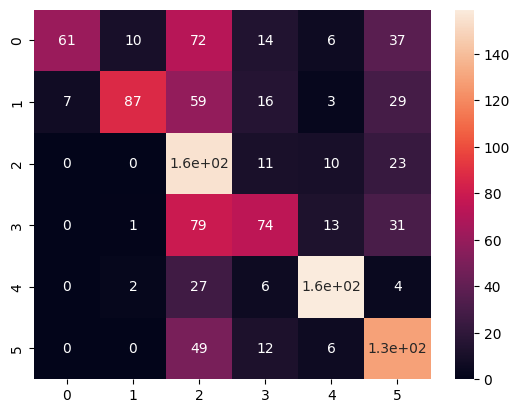

In [16]:
# Using standard scaler since it improved accuracy drastically
scaler = StandardScaler()
kNN_transform = scaler.fit_transform(bags_of_words)
kNN_test = scaler.transform(bags_of_words_test)
model = KNeighborsClassifier(n_neighbors=1, metric="euclidean")
model.fit(bags_of_words, train_df.Users)
predicted = model.predict(bags_of_words_test)

conf_mat = metrics.confusion_matrix(test_df["Users"], predicted)
plt.plot()
sns.heatmap(conf_mat, annot=True)
plt.show()

In [17]:
accuracy_score(test_df["Users"], predicted)

0.5578859060402684

In [18]:
def scikit_m_fold(dataset, train_labels, m, k):

    man_pred = []
    euc_pred = []

    for j in range(10):
        man_model = KNeighborsClassifier(n_neighbors=j+1, metric="manhattan", n_jobs=-1)
        man_pred.append(cross_val_predict(man_model, dataset, train_labels, cv=5))

        euc_model = KNeighborsClassifier(n_neighbors=j+1, metric="euclidean", n_jobs=-1)
        euc_pred.append(cross_val_predict(euc_model, dataset, train_labels, cv=5))

    return man_pred, euc_pred

In [56]:
man, euc = scikit_m_fold(bags_of_words, train_df["Users"], 5, 10)

In [57]:
acc_man_mat = [metrics.accuracy_score(train_df["Users"], man[i]) for i in range(10)]
acc_euc_mat = [metrics.accuracy_score(train_df["Users"], euc[i]) for i in range(10)]

f1_man_mat = [metrics.f1_score(train_df["Users"], man[i], average="macro") for i in range(10)]
f1_euc_mat = [metrics.f1_score(train_df["Users"], euc[i], average="macro") for i in range(10)]

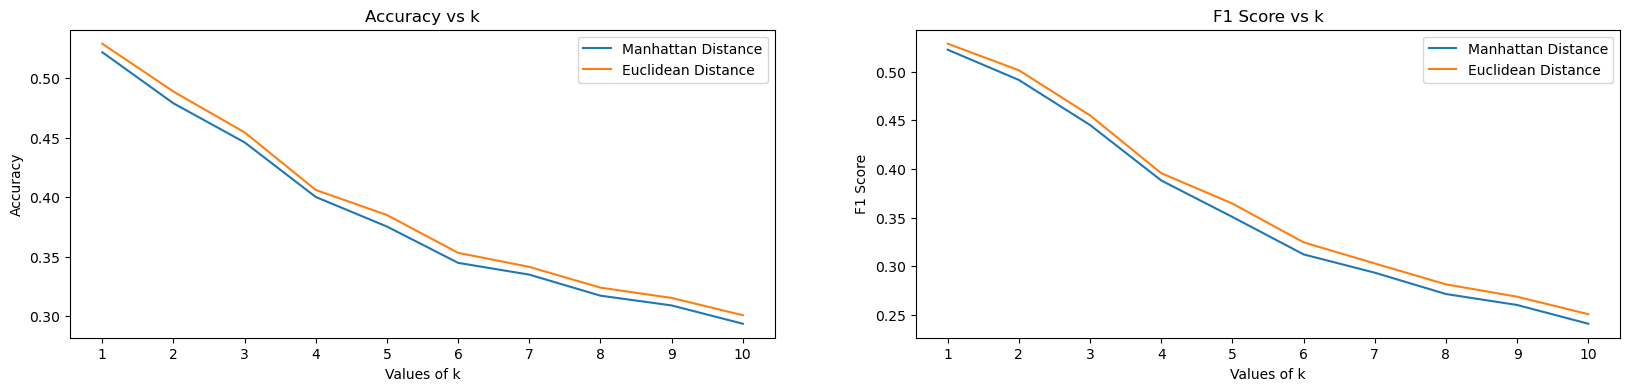

In [58]:
x_labels = [str(i+1) for i in range(10)]
plt.figure(figsize=(20,4))
plt.subplot(1,2,1)
plt.plot(x_labels, acc_man_mat)
plt.plot(x_labels, acc_euc_mat)
plt.xlabel("Values of k")
plt.ylabel("Accuracy")
plt.title("Accuracy vs k")
plt.legend(labels = ["Manhattan Distance", "Euclidean Distance"])

plt.subplot(1,2,2)
plt.plot(x_labels, f1_man_mat)
plt.plot(x_labels, f1_euc_mat)
plt.xlabel("Values of k")
plt.ylabel("F1 Score")
plt.title("F1 Score vs k")
plt.legend(labels = ["Manhattan Distance", "Euclidean Distance"])
plt.show()

Accuracy  0.7600671140939598
F1 Score:  0.7597111038076879


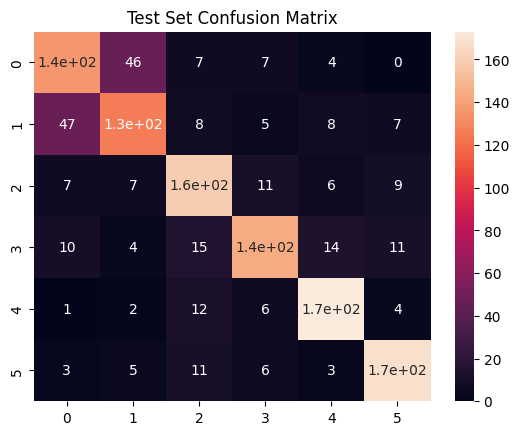

In [19]:
# Using k = 1 and euclidean distance
euc_model = KNeighborsClassifier(n_neighbors=1, metric="euclidean", n_jobs=-1)
euc_model.fit(bags_of_words, train_df["Users"])
predicted = euc_model.predict(kNN_test)

accuracy = accuracy_score(test_df["Users"], predicted)
f1 = f1_score(test_df["Users"], predicted, average="macro")
print("Accuracy ", accuracy)
print("F1 Score: ", f1)

plt.figure()
plt.title("Test Set Confusion Matrix")
sns.heatmap(confusion_matrix(test_df["Users"], predicted), annot=True)
plt.show()

> ## Neural Network:

In [9]:
# Creating training dataset

train_dataset = []

for i in range(len(train_df)):
    train_dataset.append((bags_of_words[i], train_df.iloc[i,0]))
print(len(train_dataset))

train_nn = np.array(train_dataset)
train_nn_X = train_nn[:,0]
train_nn_Y = train_nn[:,1]

reshaped = np.reshape(train_nn_X, (len(train_nn_X)))
t = np.zeros((len(train_nn_X), len(train_nn_X[0])))

for i in range(len(train_nn_X)):
    for j in range(len(train_nn_X[0])):
        t[i][j] = train_nn_X[i][j]
        
train_nn_X = t.astype(np.float64)
train_nn_Y = train_nn_Y.astype(np.float64)

4758


/var/folders/48/w55pn9w116zdyqw_nfl_fp8r0000gn/T/ipykernel_2188/1481653537.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_nn = np.array(train_dataset)


In [13]:
X_train_sc = scaler.fit_transform(train_nn_X)
clf = MLPClassifier(random_state=30, hidden_layer_sizes=(256, 128, 64, 32), activation="relu", solver='adam', learning_rate='adaptive', alpha=0.001, shuffle=True)
scores = cross_val_score(clf, X_train_sc, train_nn_Y, cv=5, n_jobs=-1)
print(scores.mean())

0.758297325239244


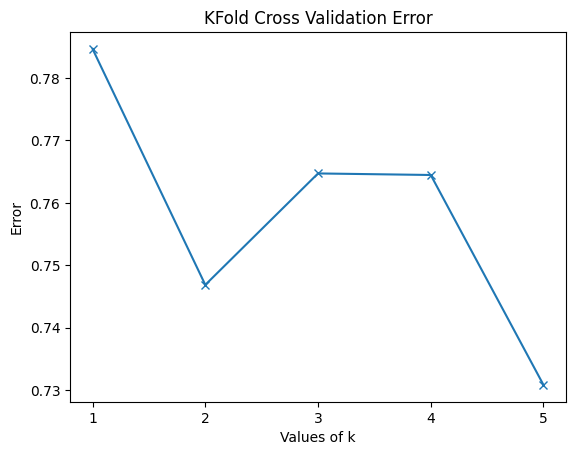

In [14]:
plt.figure()
plt.plot([str(i+1) for i in range(5)],scores, 'x-')
plt.title("KFold Cross Validation Error")
plt.xlabel("Values of k")
plt.ylabel("Error")
plt.show()

              precision    recall  f1-score   support

           0       0.74      0.74      0.74       200
           1       0.75      0.68      0.71       201
           2       0.91      0.69      0.79       199
           3       0.81      0.83      0.82       198
           4       0.92      0.88      0.90       198
           5       0.70      0.95      0.81       196

    accuracy                           0.79      1192
   macro avg       0.81      0.80      0.79      1192
weighted avg       0.81      0.79      0.79      1192



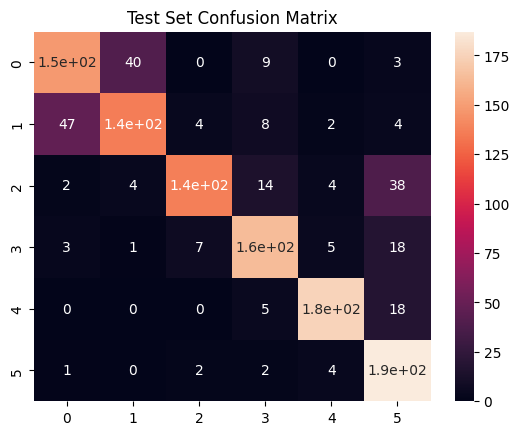

In [20]:
clf.fit(X_train_sc, train_nn_Y)

# kNN_test = scaled bag of words
predictions = clf.predict(kNN_test) 

print(classification_report(test_df['Users'], predictions))

plt.figure()
plt.title("Test Set Confusion Matrix")
sns.heatmap(confusion_matrix(test_df["Users"], predictions), annot=True)
plt.show()

> ## Ensemble Methods (Random Forest):

In [145]:
forest = RandomForestClassifier(n_estimators=3000, max_depth=2000, random_state=420, criterion='gini', n_jobs=-1)
scores = cross_val_score(forest, bags_of_words, train_df["Users"], cv=5, n_jobs=-1)
forest.fit(bags_of_words, train_df["Users"])
forest_preds = forest.predict(bags_of_words_test)
print(metrics.accuracy_score(test_df["Users"], forest_preds))

0.7550335570469798


<AxesSubplot:>

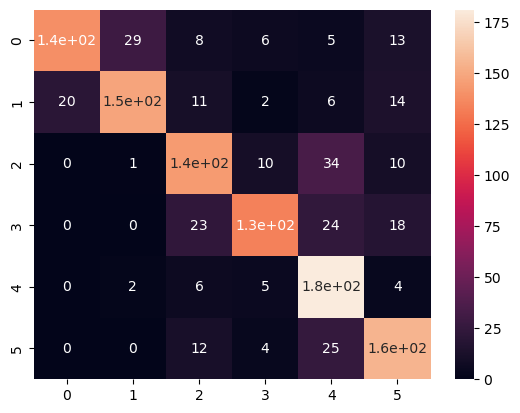

In [146]:
sns.heatmap(metrics.confusion_matrix(test_df["Users"], forest_preds), annot=True)

# 2. Word Embeddings

In [9]:

word_model = SentenceTransformer('all-MiniLM-L6-v2')
train_embeddings = word_model.encode(np.array(train_df["Tweets"]))
test_embeddings = word_model.encode(np.array(test_df["Tweets"]))

for i in range(len(train_embeddings)):
    temp = train_embeddings[i]
    temp = temp.reshape(1,-1)
    train_embeddings[i] = temp


for i in range(len(test_embeddings)):
    temp = test_embeddings[i]
    temp = temp.reshape(1,-1)
    test_embeddings[i] = temp

> ## kNN:

In [68]:
man, euc = scikit_m_fold(train_embeddings, train_df["Users"], 5, 10)

In [69]:
acc_man_mat = [metrics.accuracy_score(train_df["Users"], man[i]) for i in range(10)]
acc_euc_mat = [metrics.accuracy_score(train_df["Users"], euc[i]) for i in range(10)]

f1_man_mat = [metrics.f1_score(train_df["Users"], man[i], average="macro") for i in range(10)]
f1_euc_mat = [metrics.f1_score(train_df["Users"], euc[i], average="macro") for i in range(10)]

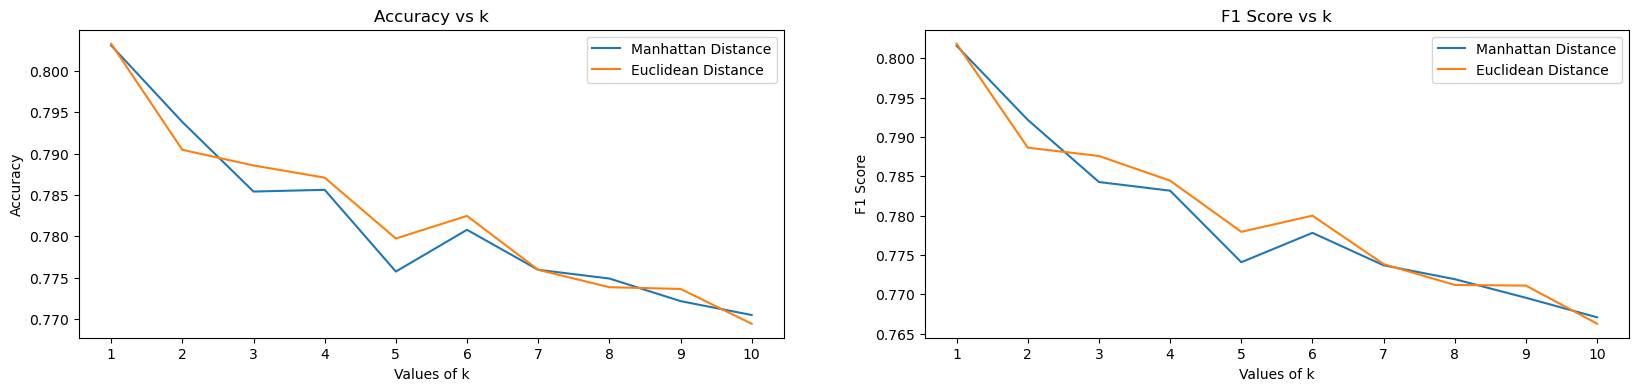

In [70]:
x_labels = [str(i+1) for i in range(10)]
plt.figure(figsize=(20,4))
plt.subplot(1,2,1)
plt.plot(x_labels, acc_man_mat)
plt.plot(x_labels, acc_euc_mat)
plt.xlabel("Values of k")
plt.ylabel("Accuracy")
plt.title("Accuracy vs k")
plt.legend(labels = ["Manhattan Distance", "Euclidean Distance"])

plt.subplot(1,2,2)
plt.plot(x_labels, f1_man_mat)
plt.plot(x_labels, f1_euc_mat)
plt.xlabel("Values of k")
plt.ylabel("F1 Score")
plt.title("F1 Score vs k")
plt.legend(labels = ["Manhattan Distance", "Euclidean Distance"])
plt.show()


Accuracy  0.8137583892617449
F1 Score:  0.8123501024819891


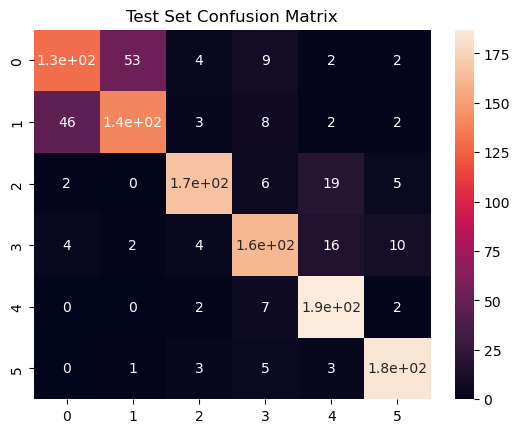

In [72]:
# Using k = 1 and euclidean distance
euc_model = KNeighborsClassifier(n_neighbors=1, metric="euclidean", n_jobs=-1)
euc_model.fit(train_embeddings, train_df["Users"])

predicted = euc_model.predict(test_embeddings)

accuracy = accuracy_score(test_df["Users"], predicted)
f1 = f1_score(test_df["Users"], predicted, average="macro")
print("Accuracy ", accuracy)
print("F1 Score: ", f1)

plt.figure()
plt.title("Test Set Confusion Matrix")
sns.heatmap(confusion_matrix(test_df["Users"], predicted), annot=True)
plt.show()


> ## Neural Network: 

In [46]:
np_y_train = np.array(train_df['Users'])
clf = MLPClassifier(random_state=30, hidden_layer_sizes=(200, 100, 50), activation="relu", alpha=0.069,  max_iter=400)
scores = cross_val_score(clf, train_embeddings, np_y_train, cv=5, n_jobs=-1)
print(scores.mean())

0.7992902208201893


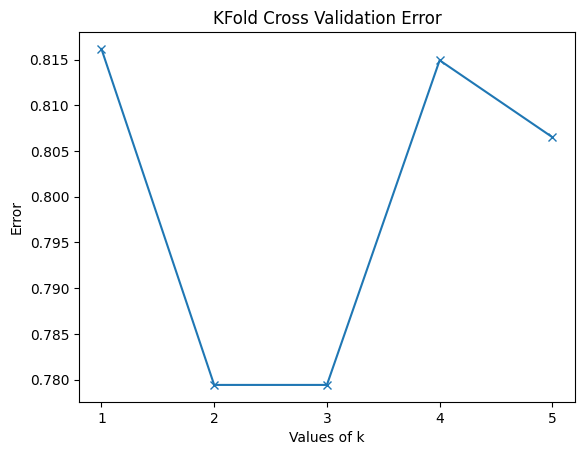

In [47]:
plt.figure()
plt.plot([str(i+1) for i in range(5)],scores, 'x-')
plt.title("KFold Cross Validation Error")
plt.xlabel("Values of k")
plt.ylabel("Error")
plt.show()

              precision    recall  f1-score   support

           0       0.76      0.78      0.77       200
           1       0.78      0.77      0.77       201
           2       0.80      0.78      0.79       199
           3       0.86      0.83      0.84       198
           4       0.83      0.91      0.87       198
           5       0.91      0.87      0.89       196

    accuracy                           0.82      1192
   macro avg       0.82      0.82      0.82      1192
weighted avg       0.82      0.82      0.82      1192



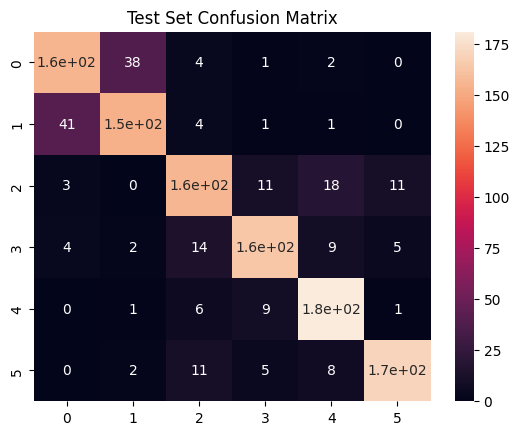

In [48]:
clf.fit(train_embeddings, np_y_train)
predictions = clf.predict(test_embeddings)

accuracy = accuracy_score(test_df["Users"], predictions)
cr = classification_report(test_df['Users'], predictions)
f1 = f1_score(test_df["Users"], predictions, average="macro")
print(cr)

plt.figure()
plt.title("Test Set Confusion Matrix")
sns.heatmap(confusion_matrix(test_df["Users"], predictions), annot=True)
plt.show()

> ## Ensemble Methods (Random Forest): 

In [17]:
forest_embeddings = RandomForestClassifier(n_estimators=50000, max_depth=10000, random_state=420, criterion='gini', n_jobs=-1)
forest_embeddings.fit(train_embeddings, train_df["Users"])
forest_embed_preds = forest_embeddings.predict(test_embeddings)
print(metrics.accuracy_score(test_df["Users"], forest_embed_preds))

0.8003355704697986


<AxesSubplot:>

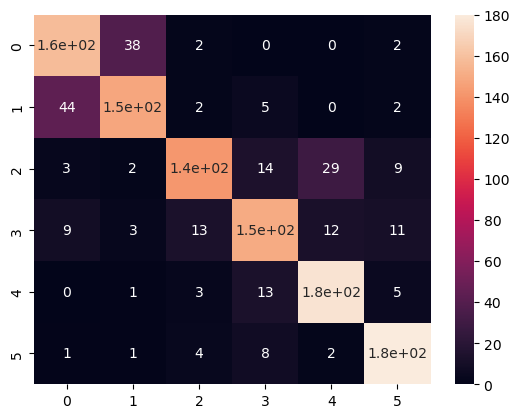

In [18]:
sns.heatmap(metrics.confusion_matrix(test_df["Users"], forest_embed_preds), annot=True)

In [ ]:
scores = cross_val_score(forest_embeddings, bags_of_words, train_df["Users"], cv=5, n_jobs=-1)
print(scores)

# Theoretical Understanding

### Q1. Which model performed best and why do you think that is?

Neural Networks performed the best, giving an accuracy of 78.9% on the test set with BoW, and an accuracy of 82% for word embeddings on the test set. Neural Networks are able to capture the dimensionality of the dataset and understand the relationships between words and their context much better in comparison to the other models. We used GridSearchCV to find the best parameters and use those for the Neural Network. One of the things that restricted the accuracy of the Neural Network (and other models) from going higher were the number of false positives encountered in the case of CNN and Wall Street Journal handles. These had very similar vocabulary. 



### Q2. Which features gave better results for each model? Explain.
Word embeddings are the state of the art NLP text representation technique in which each word is represented as a real-valued vector, and words with closer meanings are mapped closer to each other. This is the main reason behind it having a higher accuracy as it preserves some context and the meaning of the word holds much more significance than the word on its own. BOWs in contrast does not account for any meaning or context and each word is individually represented as well as newer words found in the test set cannot be accounted for and that is why it has a lower accuracy on both models. 

### Q3. What effect would increasing the classes to 150 have?
Attribution between 150 authors is a very hard task. The majority baseline performance for this task is 0.67% (1/150). As a result, increasing the number of authors will significantly degrade performance of models.


### Q4. Suggest improvements to text preparation, feature extraction, and models that can be made to perform this task better.
More reliable syntactic features, in terms of markers of styles, can be used to improve performance and accuracy such as n-grams of parts-of-speech, function words, rewrite rules etc. Moreover, adding features of a different type can lead to an increase in performance. For example, adding syntactic information, such as part-of-speech (pos) and cgp to character n-grams will increase the performance of the model. Therefore, providing a more heterogeneous feature set also typically improves performance. More generally, in terms of feature extraction, similar types of features tend to work well for small and large sets of authors because robust individual features might not emerge. 


### Q5. What - in your understanding - are the applications of authorship attribution?
Authorship attribution finds applications in a vast array of domains. These applications mainly stem from author verification through attribution. In academic settings, plagiarism detection software is built on top of foundations from authorship attribution. In legal contexts, authorship attribution can play a key role in settling copyright disputes. Similarly, in computer forensics, authorship attribution can be used to identify the creators of source code of malware. This shows that the applications of authorship attribution are not just limited to natural languages. With the increase in the amount of electronic texts, the avenues for applications of authorship attribution will only increase in the future.
